# Ames Housing Data

Below, we use data from [Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) to train a model for predicting the sales prices of houses in Ames, Iowa during the period of 2006 to 2010.

As noted by the author, Dean De Cock:

> This paper presents a data set describing the sale of individual residential property in Ames, Iowa
from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory
variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home
values.

De Cock provided a useful set of [data documentation](data/DataDocumentation.txt) as well as tips about using the data in his paper.

In [1]:
import numpy as np
import pandas as pd

# Modifying as the dataframes tend to be wide and otherwise we lose visibility into the data
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [2]:
from sklearn.model_selection import train_test_split

random_state = 42

df = pd.read_table(
    "data/AmesHousing.txt",
    index_col="PID",
)

df.columns = df.columns.str.lower().str.replace(" ", "_")

# Convert values to Boolean equivalent
df["central_air"] = df["central_air"] == "Y"
df["paved_drive"] = df["paved_drive"] == "Y"

# These columns contain nominal/ordinal values and include an option of "NA" for cases where values that
# aren't relevant for a given property. There are missing values in the data set in some cases, so I
# decided to code these as missing values as NA.
na_columns = [
    "alley",
    "bsmt_qual",
    "bsmt_cond",
    "bsmt_exposure",
    "bsmtfin_type_1",
    "bsmtfin_type_2",
    "fireplace_qu",
    "garage_type",
    "garage_finish",
    "garage_qual",
    "garage_cond",
    "pool_qc",
    "fence",
    "misc_feature",
]
df[na_columns] = df[na_columns].fillna("NA")

bmst_columns = [
    "bsmtfin_sf_1",
    "bsmtfin_sf_2",
    "bsmt_unf_sf",
    "total_bsmt_sf",
    "bsmt_full_bath",
    "bsmt_half_bath",
]

# In cases where the bsmt_quality is NA (meaning there is no basement), I opted for setting empty
# values to 0.
mask = df["bsmt_qual"] == "NA"
df.loc[mask, bmst_columns] = df.loc[mask, bmst_columns].fillna(0)

# Dropping order because not relevant. Dropping other two features due to presence of NA values.
# Intuitively, they don't seem to be factors that would have a significant impact on price.
df = df.drop(["order", "garage_yr_blt", "lot_frontage"], axis=1)

df["mas_vnr_type"] = df["mas_vnr_type"].fillna("None")
mask = (df["mas_vnr_type"] == "None") & (df["mas_vnr_area"].isna())
df.loc[mask, "mas_vnr_area"] = df.loc[mask, "mas_vnr_area"].fillna(0.0)

# This property was missing an electrical value. Rather than removing it, I decided to consult the
# data using the Ames property information directly. I changed this value based on findings at
# https://beacon.schneidercorp.com/Application.aspx?AppID=165&LayerID=2145&PageTypeID=4&PageID=1108&KeyValue=0916386080
df.loc[916386080, "electrical"] = "SBrkr"

# Based on author's comments, removing atypical examples as they skew the data and aren't representative
df = df[df.gr_liv_area <= 4000]

# Based on the author's comments, removing sales that fall outside of typical case (eg, ignoring foreclosures,
# unfinished homes, and family sales) since those sales are not representative
df = df[df.sale_condition == "Normal"]
df = df.drop(["sale_condition"], axis=1)

# Convert ordinal values to strings to aid in conversion below
for col in ["ms_subclass", "overall_qual", "overall_cond"]:
    df[col] = df[col].astype("str")

df

,ms_subclass,ms_zoning,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
PID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
526301100,20,RL,31770,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,True,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,Fin,2.0,528.0,TA,TA,False,210,62,0,0,0,0,NA,NA,NA,0,5,2010,WD,215000
526350040,20,RH,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,True,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,Unf,1.0,730.0,TA,TA,True,140,0,0,0,120,0,NA,MnPrv,NA,0,6,2010,WD,105000
526351010,20,RL,14267,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,True,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NA,Attchd,Unf,1.0,312.0,TA,TA,True,393,36,0,0,0,0,NA,NA,Gar2,12500,6,2010,WD,172000
526353030,20,RL,11160,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,True,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,Fin,2.0,522.0,TA,TA,True,0,0,0,0,0,0,NA,NA,NA,0,4,2010,WD,244000
527105010,60,RL,13830,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,True,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,Fin,2.0,482.0,TA,TA,True,212,34,0,0,0,0,NA,MnPrv,NA,0,3,2010,WD,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923275080,80,RL,7937,Pave,NA,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,GasA,TA,True,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NA,Detchd,Unf,2.0,588.0,TA,TA,True,120,0,0,0,0,0,NA,GdPrv,NA,0,3,2006,WD,142500
923276100,20,RL,8885,Pave,NA,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,GasA,TA,True,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NA,Attchd,Unf,2.0,484.0,TA,TA,True,164,0,0,0,0,0,NA,MnPrv,NA,0,6,2006,WD,131000
923400125,85,RL,10441,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,SFoyer,5,5,1992,1992,Gable,CompShg,HdBoard,Wd Shng,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,337.0,Unf,0.0,575.0,912.0,GasA,TA,True,SBrkr,970,0,0,970,0.0,1.0,1,0,3,1,TA,6,Typ,0,NA,NA,NA,0.0,0.0,NA,NA,True,80,32,0,0,0,0,NA,MnPrv,Shed,700,7,2006,WD,132000


Check for NA values

In [3]:
null_counts = pd.DataFrame(df.isnull().sum(), columns=["nulls"])
null_counts[null_counts.nulls > 0]

,nulls


Create train/validation/test data and determine categorical vs numerical columns

In [4]:
df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=random_state,
)
df_train, df_val = train_test_split(
    df_full_train, test_size=0.25, random_state=random_state
)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train["saleprice"]
y_train = df_train["saleprice"]
y_val = df_val["saleprice"]
y_test = df_test["saleprice"]

df_full_train = df_full_train.drop(["saleprice"], axis=1)
df_train = df_train.drop(["saleprice"], axis=1)
df_val = df_val.drop(["saleprice"], axis=1)
df_test = df_test.drop(["saleprice"], axis=1)

categorical_columns = list(df_train.dtypes[df_train.dtypes == "object"].index)
numerical_columns = list(df_train.dtypes[df_train.dtypes != "object"].index)

print(f"categorical columns: {categorical_columns}")
print()
print(f"numerical columns: {numerical_columns}")

categorical columns: ['ms_subclass', 'ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'electrical', 'kitchen_qual', 'functional', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature', 'sale_type']

numerical columns: ['lot_area', 'year_built', 'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'central_air', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_cars',

In [5]:
df_train[numerical_columns]

,lot_area,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,central_air,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_cars,garage_area,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
0,4928,1976,1976,0.0,958.0,0.0,0.0,958.0,True,958,0,0,958,0.0,0.0,2,0,2,1,5,0,2.0,440.0,True,0,60,0,0,0,0,0,10,2009
1,4571,1910,1950,0.0,168.0,0.0,448.0,616.0,True,616,616,0,1232,0.0,0.0,1,0,3,1,6,0,2.0,480.0,True,280,0,143,0,0,0,0,6,2007
2,12180,1941,1950,0.0,348.0,0.0,324.0,672.0,False,672,252,0,924,1.0,0.0,1,0,2,1,5,0,1.0,280.0,True,0,0,0,0,0,0,0,7,2010
3,17500,1954,1954,420.0,784.0,435.0,91.0,1310.0,True,1906,0,0,1906,1.0,0.0,1,1,3,1,6,2,2.0,576.0,True,0,201,0,0,0,0,0,1,2009
4,4485,1920,1950,0.0,579.0,0.0,357.0,936.0,True,936,0,0,936,1.0,0.0,1,0,2,1,5,1,0.0,0.0,False,51,0,135,0,0,0,0,5,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,9750,1958,1958,243.0,608.0,0.0,834.0,1442.0,True,1442,0,0,1442,0.0,0.0,1,1,4,1,7,0,1.0,301.0,True,0,0,275,0,0,0,500,4,2007
1442,1612,1980,1980,0.0,0.0,0.0,561.0,561.0,True,561,668,0,1229,0.0,0.0,1,1,2,1,5,1,2.0,462.0,True,154,0,0,0,0,0,0,7,2009
1443,8965,2003,2003,0.0,652.0,0.0,130.0,782.0,True,806,683,0,1489,1.0,0.0,2,1,3,1,8,1,2.0,400.0,True,0,75,0,0,0,0,0,6,2009
1444,12144,1950,1950,0.0,455.0,0.0,455.0,910.0,True,910,611,0,1521,0.0,0.0,1,1,3,1,6,0,1.0,597.0,True,199,0,168,0,0,0,0,9,2006


In [6]:
df_train[categorical_columns]

,ms_subclass,ms_zoning,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_type_2,heating,heating_qc,electrical,kitchen_qual,functional,fireplace_qu,garage_type,garage_finish,garage_qual,garage_cond,pool_qc,fence,misc_feature,sale_type
0,120,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,NPkVill,Norm,Norm,TwnhsE,1Story,6,6,Gable,CompShg,Plywood,Plywood,None,TA,TA,CBlock,Gd,TA,No,LwQ,Unf,GasA,TA,SBrkr,TA,Typ,NA,Attchd,RFn,TA,TA,NA,NA,NA,WD
1,70,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,5,7,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,BrkTil,TA,TA,No,BLQ,Unf,GasA,Ex,SBrkr,TA,Typ,NA,Detchd,Unf,Fa,Fa,NA,NA,NA,WD
2,190,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1.5Fin,4,4,Gable,CompShg,MetalSd,MetalSd,None,TA,Fa,BrkTil,Gd,TA,No,BLQ,Unf,Grav,Fa,FuseA,Fa,Typ,NA,Detchd,Unf,TA,TA,NA,MnPrv,NA,WD
3,20,RL,Pave,NA,Reg,Bnk,AllPub,Corner,Mod,Crawfor,PosA,Norm,1Fam,1Story,6,5,Gable,CompShg,HdBoard,HdBoard,Stone,TA,TA,PConc,TA,TA,Av,LwQ,BLQ,GasA,Ex,SBrkr,TA,Typ,Gd,Basment,Unf,TA,TA,NA,NA,NA,WD
4,30,RM,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,5,7,Gable,CompShg,Wd Sdng,Wd Sdng,None,TA,TA,PConc,TA,TA,No,BLQ,Unf,GasA,TA,SBrkr,TA,Typ,Gd,NA,NA,NA,NA,NA,MnPrv,NA,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1441,20,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,MetalSd,MetalSd,BrkFace,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Gd,SBrkr,TA,Typ,NA,Attchd,RFn,TA,TA,NA,NA,Shed,COD
1442,160,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Blueste,Norm,Norm,Twnhs,2Story,6,6,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,No,Unf,Unf,GasA,TA,SBrkr,TA,Typ,TA,Attchd,Fin,TA,TA,NA,MnPrv,NA,WD
1443,60,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,None,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,SBrkr,Gd,Typ,Gd,Attchd,Fin,TA,TA,NA,NA,NA,WD
1444,50,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,4,6,Gable,CompShg,BrkComm,Wd Sdng,None,TA,TA,CBlock,TA,TA,No,Rec,Unf,GasA,Gd,SBrkr,Gd,Min2,NA,Detchd,Unf,Fa,TA,NA,NA,NA,WD


In [7]:
df_train.describe()

,lot_area,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold
count,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000,1446.000000
mean,9957.282158,1968.990318,1983.058783,94.408022,430.730982,55.524896,529.042877,1015.298755,1126.616874,345.070539,4.848548,1476.535961,0.425311,0.059474,1.537344,0.385201,2.865145,1.040802,6.373444,0.605809,1.729599,458.884509,94.387275,44.019364,23.221992,2.608575,15.587137,1.258645,38.426694,6.111342,2007.850622
std,6241.598781,29.538455,20.321499,174.953014,409.317885,180.142709,417.170385,405.892357,359.705121,425.506954,50.857681,480.412870,0.513778,0.239499,0.542634,0.499441,0.812831,0.204775,1.532201,0.655723,0.737185,201.510118,133.730393,62.863489,60.902894,25.535896,54.760280,27.968510,408.053991,2.616302,1.327832
min,1300.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,7226.250000,1951.000000,1965.000000,0.000000,0.000000,0.000000,210.000000,780.000000,864.000000,0.000000,0.000000,1099.250000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,312.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,9350.000000,1971.000000,1990.000000,0.000000,382.000000,0.000000,437.500000,960.000000,1059.000000,0.000000,0.000000,1428.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,466.500000,0.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,11339.750000,1998.000000,2002.000000,143.750000,705.500000,0.000000,778.500000,1241.500000,1344.000000,716.000000,0.000000,1716.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,572.000000,168.000000,65.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2009.000000
max,115149.000000,2009.000000,2009.000000,1600.000000,2288.000000,1526.000000,2336.000000,3206.000000,3228.000000,1836.000000,1064.000000,3672.000000,2.000000,2.000000,4.000000,2.000000,6.000000,3.000000,13.000000,4.000000,5.000000,1356.000000,1424.000000,570.000000,584.000000,407.000000,490.000000,800.000000,12500.000000,12.000000,2010.000000


Look at sales price to determine its distribution

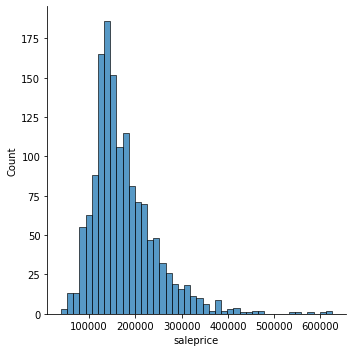

In [8]:
import seaborn as sns

sns.displot(y_train)

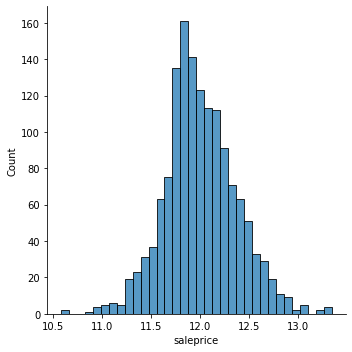

In [9]:
sns.displot(np.log1p(y_train))

Because the log transformed sales price is a normal distribution, use that form for model fitting

In [10]:
y_full_train = np.log1p(y_full_train)
y_train = np.log1p(y_train)
y_val = np.log1p(y_val)
y_test = np.log1p(y_test)

In [11]:
corr = df_train[numerical_columns].corrwith(y_train).abs()
corr[(corr >= 0.1)].sort_values(ascending=False)

gr_liv_area       0.739416
garage_cars       0.663489
garage_area       0.650281
total_bsmt_sf     0.618299
1st_flr_sf        0.605745
full_bath         0.592500
year_built        0.575456
year_remod/add    0.559616
totrms_abvgrd     0.522214
fireplaces        0.505173
bsmtfin_sf_1      0.441519
mas_vnr_area      0.405871
central_air       0.370185
open_porch_sf     0.348140
wood_deck_sf      0.347475
paved_drive       0.342527
half_bath         0.326333
2nd_flr_sf        0.326238
lot_area          0.321195
bsmt_full_bath    0.297078
bedroom_abvgr     0.237793
bsmt_unf_sf       0.142818
enclosed_porch    0.141935
screen_porch      0.133630
kitchen_abvgr     0.115937
dtype: float64

From ML Zoomcamp Office Hours -- Week 8:

> When feature is categorical and target is numerical, turn target into categorical and use mutual information

In [12]:
qprice = pd.qcut(np.log1p(y_train), q=10)
qprice

0        (2.55, 2.556]
1       (2.531, 2.544]
2       (2.448, 2.531]
3       (2.588, 2.601]
4       (2.531, 2.544]
             ...      
1441    (2.556, 2.563]
1442    (2.531, 2.544]
1443    (2.571, 2.578]
1444    (2.556, 2.563]
1445     (2.55, 2.556]
Name: saleprice, Length: 1446, dtype: category
Categories (10, interval[float64, right]): [(2.448, 2.531] < (2.531, 2.544] < (2.544, 2.55] < (2.55, 2.556] ... (2.571, 2.578] < (2.578, 2.588] < (2.588, 2.601] < (2.601, 2.663]]

In [13]:
from sklearn.metrics import mutual_info_score


def calculate_mi(series):
    return mutual_info_score(series, qprice)


df_mi = df_train[categorical_columns].apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name="MI")
df_mi

,MI
neighborhood,0.548663
overall_qual,0.504782
ms_subclass,0.323977
bsmt_qual,0.282997
kitchen_qual,0.273312
exter_qual,0.269638
garage_finish,0.225034
garage_type,0.208106
foundation,0.207901
fireplace_qu,0.203215


> found about 80% of the variation in residential sales price can be explained by simply taking into
consideration the neighborhood and total square footage (TOTAL BSMT SF + GR LIV AREA) of
the dwelling.

In [14]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)
dv.fit(df[categorical_columns + numerical_columns].to_dict(orient="records"))

full_train_dict = df_full_train[categorical_columns + numerical_columns].to_dict(
    orient="records"
)
X_full_train = dv.transform(full_train_dict)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient="records")
X_train = dv.transform(train_dict)

val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient="records")
X_val = dv.transform(val_dict)

test_dict = df_test[categorical_columns + numerical_columns].to_dict(orient="records")
X_test = dv.transform(test_dict)

In [15]:
# noinspection PyPep8Naming
def output_grid_search_results(grid_search_model, X, y) -> None:
    print(f"Best Params:\t{grid_search_model.best_params_}")
    print(f"Best Train R2:\t{grid_search_model.best_score_}")

    print(f"Val R2:\t{grid_search_model.score(X, y)}")

    y_pred = grid_search_model.predict(X)
    print(f"Val RMSE:\t{mean_squared_error(y, y_pred, squared=False)}")

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        ("regr", LinearRegression()),
    ]
)
parameters = [
    {
        "regr": [Ridge(random_state=random_state)],
        "regr__alpha": np.logspace(-4, 1, 6),
    },
    {
        "regr": [Lasso(max_iter=4000, random_state=random_state)],
        "regr__alpha": np.logspace(-4, 1, 6),
    },
    {
        "regr": [ElasticNet(max_iter=4000, random_state=random_state)],
        "regr__alpha": [0.01],  # np.logspace(-4, 1, 6),
        "regr__l1_ratio": [0.1],  # [0.001, 0.01, 0.1, 1],
    },
]
grid_search = GridSearchCV(pipeline, parameters, cv=10, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

output_grid_search_results(grid_search, X_val, y_val)

Fitting 10 folds for each of 13 candidates, totalling 130 fits
Best Params:	{'regr': ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=4000, random_state=42), 'regr__alpha': 0.01, 'regr__l1_ratio': 0.1}
Best Train R2:	0.9358024765182842
Val R2:	0.9337647220999508
Val RMSE:	0.09285740948082344


In [17]:
import xgboost as xgb

xgbr = xgb.XGBRegressor(
    objective="reg:squarederror", random_state=random_state, n_jobs=-1
)
parameters = {
    "learning_rate": [0.1],  # np.linspace(0.01, .1, 10),
    "max_depth": [9],  # np.arange(1, 11), #[3, 4, 10],
    "min_child_weight": [12],  # np.arange(1, 31),
    "subsample": [1],  # np.arange(0.4, 1.1, .1),
    "colsample_bytree": [1],  # np.linspace(0.0, 1.0, 11)
}
xgb_grid = GridSearchCV(xgbr, parameters, cv=10, n_jobs=-1, verbose=1)

xgb_grid.fit(X_train, y_train)

output_grid_search_results(xgb_grid, X_val, y_val)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best Params:	{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 12, 'subsample': 1}
Best Train R2:	0.9243422785725492
Val R2:	0.9172183270343519
Val RMSE:	0.10380994996442554


In [18]:
# noinspection PyPep8Naming
def output_model_results(m, X, y) -> None:
    print(f"Test R2:\t{m.score(X, y)}")

    y_pred = m.predict(X)
    print(f"Test RMSE:\t{mean_squared_error(y, y_pred, squared=False)}")

In [19]:
model = Pipeline(
    [
        ("scale", StandardScaler()),
        ("regr", ElasticNet(alpha=0.01, l1_ratio=0.1, max_iter=4000, random_state=42)),
    ]
)

model.fit(X_full_train, y_full_train)

output_model_results(model, X_test, y_test)

Test R2:	0.9437396731403637
Test RMSE:	0.08940930416822403


In [20]:
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.1,
    max_depth=9,
    min_child_weight=12,
    subsample=1,
    colsample_bytree=1,
    random_state=random_state,
    n_jobs=-1,
)

model.fit(X_full_train, y_full_train)

output_model_results(model, X_test, y_test)

Test R2:	0.9302015549214713
Test RMSE:	0.09958741589410425
